# Identifying Age Related Conditions
## Logistic Regression

In [189]:
# Util
from datetime import datetime
import os
import math
from functools import reduce
import operator

# Extraction
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

# Transformation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

## Download Files

In [185]:
api = KaggleApi()
api.authenticate()

In [7]:
api.competition_list_files('icr-identify-age-related-conditions')

[train.csv, sample_submission.csv, test.csv, greeks.csv]

In [11]:
# api.competition_download_files('icr-identify-age-related-conditions')

zf = ZipFile('icr-identify-age-related-conditions.zip')
zf.extractall('Data/') #save files in selected folder
zf.close()

## Merge and Transform Data

In [177]:
train_df = pd.read_csv('Data/train.csv')
meta_train_df = pd.read_csv('Data/greeks.csv')

# Merge train data and meta data
train_df = train_df.merge(meta_train_df[['Id','Alpha']], on='Id')
# Create more specific class using meta data (A, B, D, G)
train_df['ClassB'] = train_df.apply(lambda x: int(x['Alpha']=='B'), axis=1)
train_df['ClassD'] = train_df.apply(lambda x: int(x['Alpha']=='D'), axis=1)
train_df['ClassG'] = train_df.apply(lambda x: int(x['Alpha']=='G'), axis=1)
# Convert 'EJ' categorical column to binary
train_df['EJ'] = train_df.apply(lambda x: int(x['EJ'] == 'A'), axis=1)

# Drop categorical 'Alpha' column
train_df = train_df.drop(columns=['Alpha'])

# Fill NaN values with column average
drop_dict = train_df.drop(columns=['Id']).median()
train_df = train_df.fillna(drop_dict)

train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GB,GE,GF,GH,GI,GL,Class,ClassB,ClassD,ClassG
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,1,0,0
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,0,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,1,0


## Visualize Data

<Figure size 2880x2304 with 0 Axes>

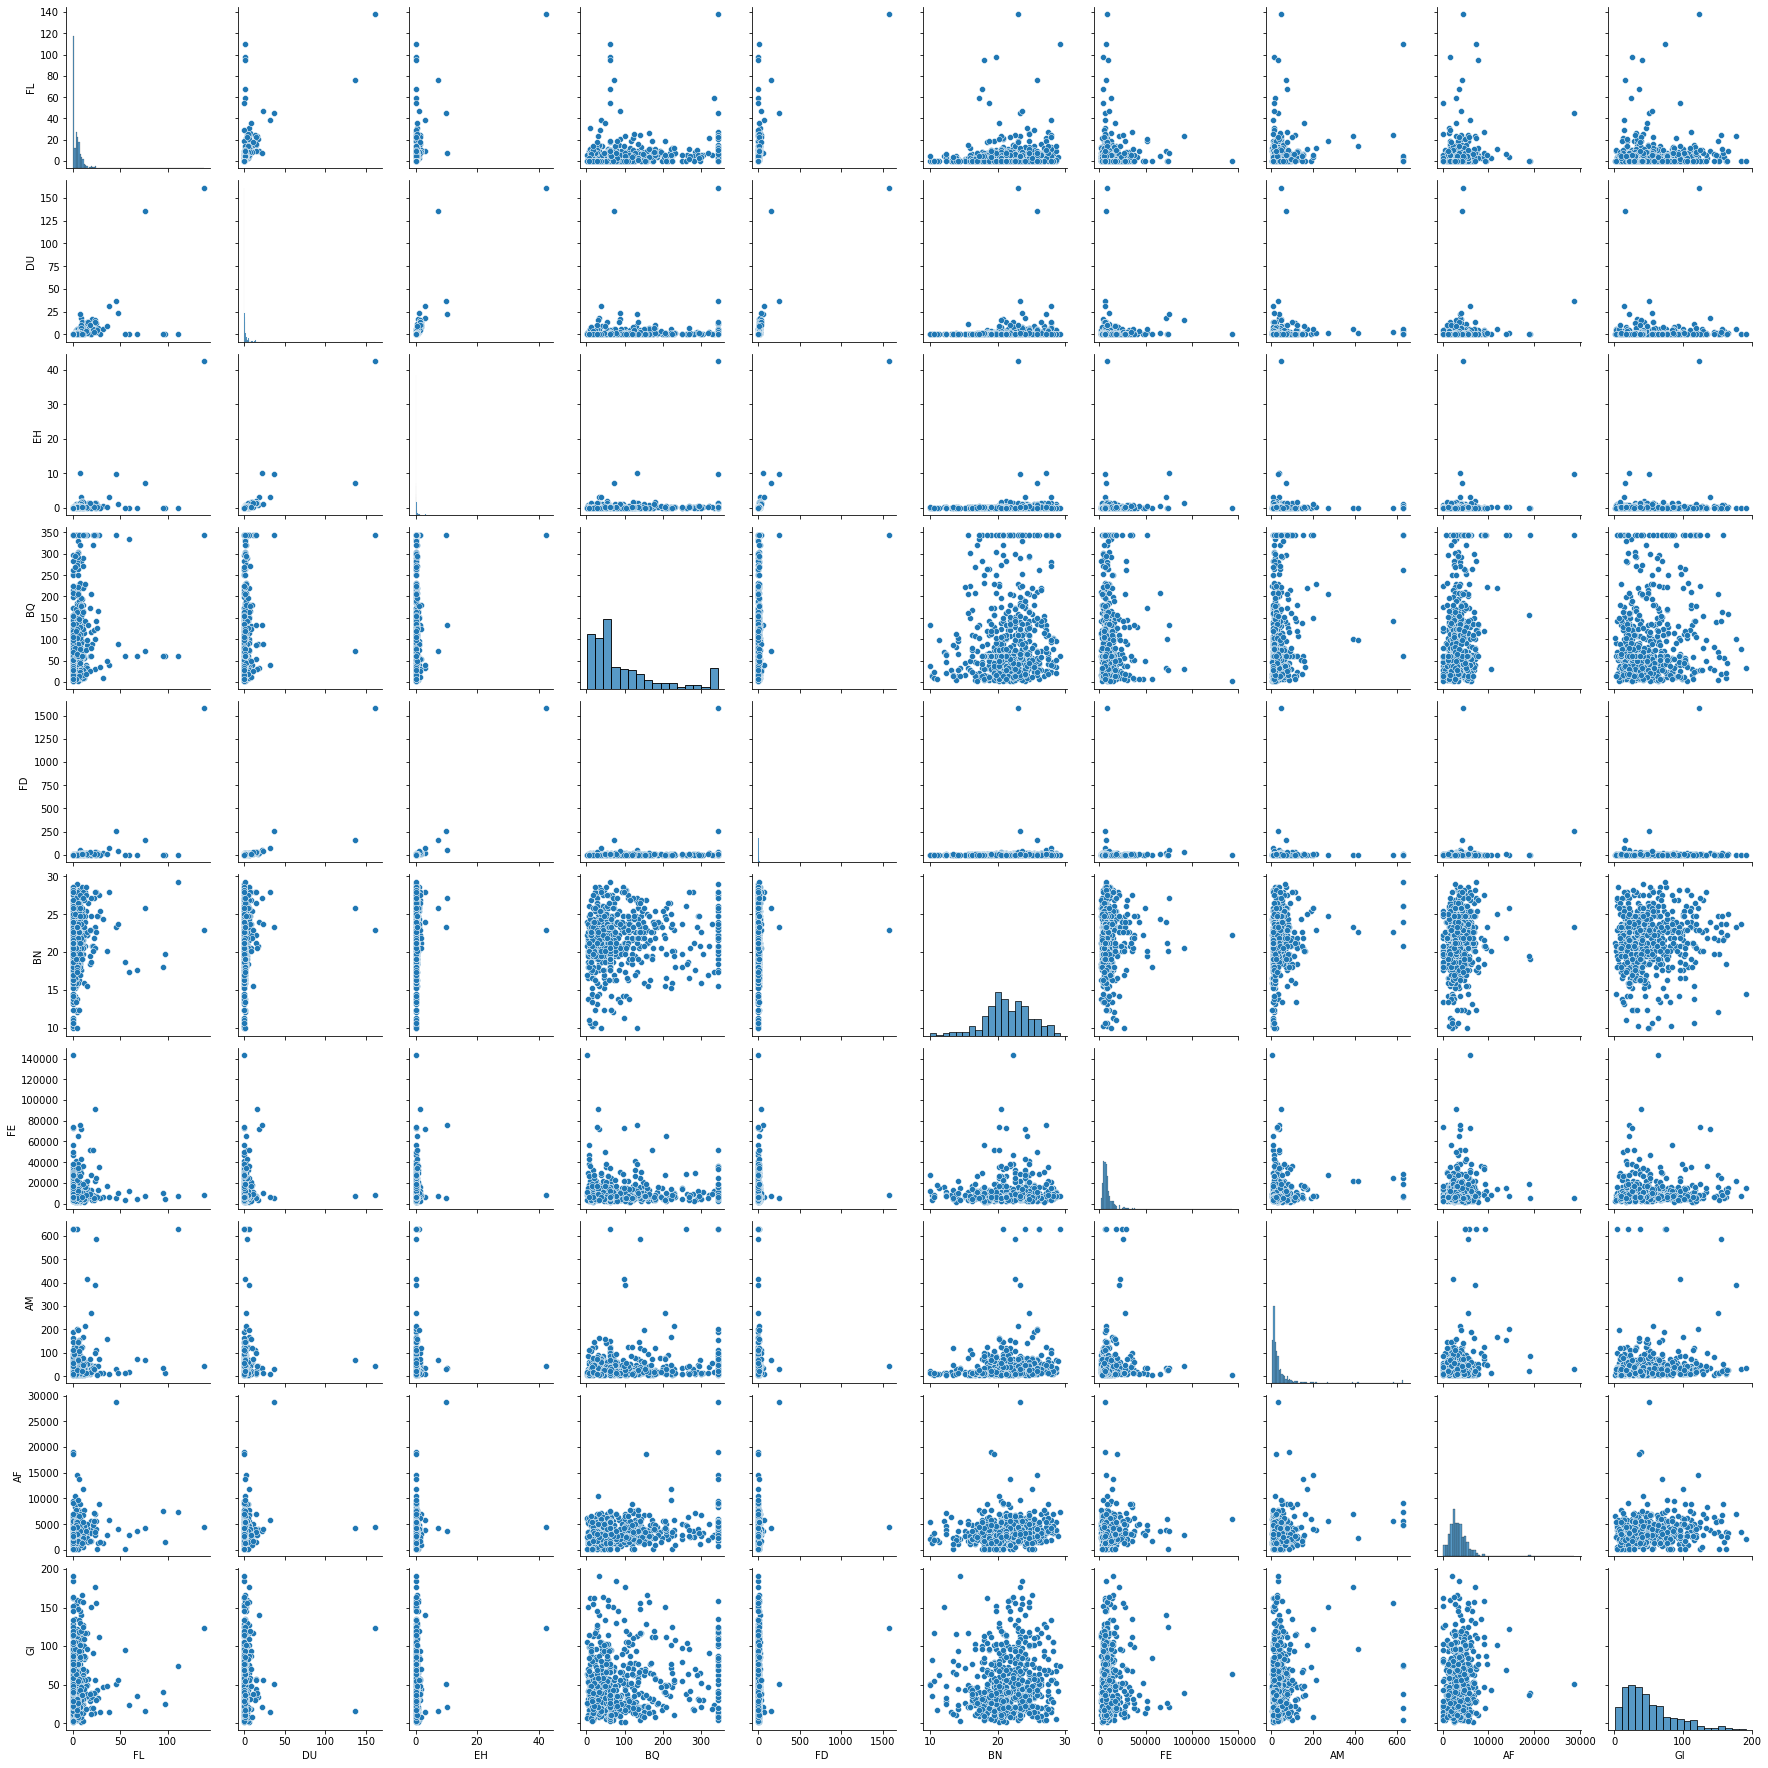

In [183]:
tgt = 'ClassB'

cor_mat = train_df.corr()
cor_mat[tgt] = cor_mat.apply(lambda x: x[tgt]**2, axis=1)

cols = [c for c in cor_mat.columns if c not in ('Class','ClassB','ClassD','ClassG','EJ')]
cols_top10 = cor_mat.loc[cols].sort_values(by=tgt, ascending=False).iloc[:10].index

plt.figure(figsize=(40, 32))

sns.pairplot(train_df[cols_top10])
plt.show()

In [106]:
stats = {'min':train_df.drop(columns='Id').min(), 
         'max':train_df.drop(columns='Id').max(),
         'median':train_df.drop(columns='Id').median(), 
         'q1':train_df.drop(columns='Id').quantile(0.25), 
         'q3':train_df.drop(columns='Id').quantile(0.75)}

stats_df = pd.DataFrame(stats)
stats_df['iqr'] = stats_df.apply(lambda x: x['q3']-x['q1'], axis=1)
stats_df['min_threshold'] = stats_df.apply(lambda x: x['q1']-1.5*x['iqr'], axis=1)
stats_df['max_threshold'] = stats_df.apply(lambda x: x['q3']+1.5*x['iqr'], axis=1)

stats_df.head()

,min,max,median,q1,q3,iqr,min_threshold,max_threshold
AB,0.081187,6.161666,0.354659,0.252107,0.559763,0.307656,-0.209377,1.021247
AF,192.593280,28688.187660,3120.318960,2197.345480,4361.637390,2164.291910,-1049.092385,7608.075255
AH,85.200147,1910.123198,85.200147,85.200147,113.739540,28.539393,42.391057,156.548630
AM,3.177522,630.518230,20.533110,12.270314,39.139886,26.869572,-28.034044,79.444244
AR,8.138688,178.943634,8.138688,8.138688,8.138688,0.000000,8.138688,8.138688


## Train Lasso Logistic Regression Model

### Define loss function

In [111]:
def logloss(y_obs, y_act):
    '''
    inputs: y_obs, array of observed probabilities (between 0 and 1)
            y_act, array of binary values (0 or 1)
    output: loss as negative average of log of corrected probabilities
    '''
    return -np.mean([y*math.log(x) + (1-y)*math.log(1-x) for x,y in list(zip(y_obs, y_act)) if x < 1 and x > 0])

### Tune hyperparameters and train model
For each positive class outcome (B, D, G), train a separate logistic regression model to determine probability of each, and use these predictions to calculate the overall probability of a positive class outcome (the likelihood that we observe B, D, or G).

Because we have upwards of 50 features, some form of feature selection is likely necesssary to avoid overfitting. In this case, I will use Lasso (L1 norm regularization) to shrink the coefficients of each feature (in some cases, all the way to 0). Lasso requires a value $\lambda$ to determine the severity of shrinkage, so I will experiment with a number of different values for this parameter.

In [186]:
targets = ['ClassB','ClassD','ClassG']
params_range = [10**i for i in range(-3,4)]

model_dict = {}
coef_dict = {}

for tgt in targets:
    # Split into train and test with 30% of data reserved for test
    cols = [c for c in train_df.columns if 'Class' not in c and 'Id' not in c]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(train_df[cols], train_df[tgt], test_size=0.3, \
                                                                        random_state=47, stratify=train_df[tgt])

    # Normalize training data (necessary for Lasso regression to work)
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train_norm = min_max_scaler.fit_transform(X_train)
    X_test_norm = min_max_scaler.fit_transform(X_test)

    # Set initial parameters
    best_score = math.inf
    best_lambda = 1
    best_model = None

    # Test different regularization strengths
    for LAMBDA_PARAM in params_range:

        # Set new value for regularization parameter
        print('------------------------------------\nREGULARIZATION PARAMETER = ', \
              LAMBDA_PARAM, '\n------------------------------------')

        # Train logistic regression model with liblinear solver and L1 regularlizer
        model = linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=1/LAMBDA_PARAM, random_state=4747)
        model.fit(X_train_norm, y_train)

        # Predict probabilities (0 to 1) from training and test data
        y_pred_train_proba = model.predict_proba(X_train_norm)
        y_pred_test_proba = model.predict_proba(X_test_norm)

        # Calculate entropy (logloss) of predicted probabilities against the actual values
        score = logloss([x[1] for x in y_pred_test_proba], y_test.values)
        print("LOGLOSS: {}\n".format(score))

        # Predict values from training and test data
        y_pred_train = model.predict(X_train_norm)
        y_pred_test = model.predict(X_test_norm)

        # Retrieve confusion matrix for train and test sets
        train_cm = metrics.confusion_matrix(y_train, y_pred_train)
        test_cm = metrics.confusion_matrix(y_test, y_pred_test)

        # TRAIN
        # Retrieve number of true positives/negatives, false positives/negatives from confusion matrix
        train_tn, train_fp, train_fn, train_tp = train_cm.ravel()
        # Calculate precision (correct positive / retrieved positive) and recall (correct positive / relevant [actual] positive)
        if train_tp + train_fp > 0:
            train_precision = train_tp / (train_tp + train_fp)
        else:
            train_precision = np.nan
        if train_tp + train_fn > 0:
            train_recall = train_tp / (train_tp + train_fn)
        else:
            train_recall = np.nan
        # Calculate accuracy (total correct / all)
        train_accuracy = (train_tp + train_tn) / (train_tp + train_tn + train_fp + train_fn)

        print('-- TRAIN --\nPRECISION:\t', train_precision, '\nRECALL:\t\t', train_recall, '\nACCURACY:\t', train_accuracy, '\n')

        # TEST
        # Retrieve number of true positives/negatives, false positives/negatives from confusion matrix
        test_tn, test_fp, test_fn, test_tp = test_cm.ravel()
        # Calculate precision (correct positive / retrieved positive) and recall (correct positive / relevant [actual] positive)
        if test_tp + test_fp > 0:
            test_precision = test_tp / (test_tp + test_fp)
        else:
            test_precision = np.nan
        if test_tp + test_fn > 0:
            test_recall = test_tp / (test_tp + test_fn)
        else:
            test_recall = np.nan
        # Calculate accuracy (total correct / all)
        test_accuracy = (test_tp + test_tn) / (test_tp + test_tn + test_fp + test_fn)

        print('-- TEST --\nPRECISION:\t', test_precision, '\nRECALL:\t\t', test_recall, '\nACCURACY:\t', test_accuracy, '\n')

        # Update best_score and best_lambda if logloss is lower than previously seen
        if score < best_score:
            best_score = score
            best_lambda = LAMBDA_PARAM
            best_model = model

    # Print best value of lambda
    print('\n------------------------------------\nBEST REGULARIZATION PARAMETER = ', best_lambda)

    # Identify the most important (heaviest weighted) features in the model
    d = dict(zip(X_train.columns, best_model.coef_[0]))
    d = dict(sorted(d.items(), reverse=True, key=lambda item: abs(item[1])))

    # Save the top model
    model_dict[tgt] = best_model
    
    # Save coefficients of top model
    coef_dict[tgt] = d

    print('TOP FEATURES:\t', list(d.keys())[:10])
    
feature_df = pd.DataFrame(coef_dict).sort_index()
feature_df.to_csv('Features/lasso_features.csv', index=None)

------------------------------------
REGULARIZATION PARAMETER =  0.001 
------------------------------------
LOGLOSS: 49.533966044826876

-- TRAIN --
PRECISION:	 1.0 
RECALL:		 0.9534883720930233 
ACCURACY:	 0.9953596287703016 

-- TEST --
PRECISION:	 0.3333333333333333 
RECALL:		 0.05555555555555555 
ACCURACY:	 0.8978494623655914 

------------------------------------
REGULARIZATION PARAMETER =  0.01 
------------------------------------
LOGLOSS: 2.4218848983107066

-- TRAIN --
PRECISION:	 0.8974358974358975 
RECALL:		 0.813953488372093 
ACCURACY:	 0.9721577726218097 

-- TEST --
PRECISION:	 0.4166666666666667 
RECALL:		 0.2777777777777778 
ACCURACY:	 0.8924731182795699 

------------------------------------
REGULARIZATION PARAMETER =  0.1 
------------------------------------
LOGLOSS: 0.30214872151821437

-- TRAIN --
PRECISION:	 0.8235294117647058 
RECALL:		 0.6511627906976745 
ACCURACY:	 0.951276102088167 

-- TEST --
PRECISION:	 0.6666666666666666 
RECALL:		 0.3333333333333333 
ACC

In [187]:
# Split into train and test with 30% of data reserved for test
cols = [c for c in train_df.columns if 'Class' not in c and 'Id' not in c]
X_pred = train_df[cols].copy()
y_pred = train_df[targets].copy()

for tgt in ['ClassB', 'ClassD', 'ClassG']:
    
    # Normalize training data (necessary for Lasso regression to work)
    min_max_scaler = preprocessing.MinMaxScaler()
    X_pred_norm = min_max_scaler.fit_transform(X_pred)

    # Predict probabilities (0 to 1) from training and test data
    y_pred_proba = model_dict[tgt].predict_proba(X_pred_norm)

    y_pred[f'{tgt}_pred'] = [x[1] for x in y_pred_proba]
    
y_pred['Class'] = y_pred.apply(lambda x: max([x[tgt] for tgt in targets]), axis=1)
y_pred['Class_pred'] = y_pred.apply(lambda x: 1 - reduce(operator.mul, [1-x[f'{tgt}_pred'] for tgt in targets]), axis=1)

# Calculate entropy (logloss) of predicted probabilities against the actual values
score = logloss(y_pred['Class_pred'].values, y_pred['Class'].values)
print("LOGLOSS: {}\n".format(score))

cm = metrics.confusion_matrix(y_pred['Class'], [int(y>0.5) for y in y_pred['Class_pred']])

# TRAIN
# Retrieve number of true positives/negatives, false positives/negatives from confusion matrix
tn, fp, fn, tp = cm.ravel()
# Calculate precision (correct positive / retrieved positive) and recall (correct positive / relevant [actual] positive)
if tp + fp > 0:
    precision = tp / (tp + fp)
else:
    precision = np.nan
if tp + fn > 0:
    recall = tp / (tp + fn)
else:
    recall = np.nan
# Calculate accuracy (total correct / all)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print('\nPRECISION:\t', precision, '\nRECALL:\t\t', recall, '\nACCURACY:\t', accuracy, '\n')
        
y_pred

LOGLOSS: 0.35654110794403704


PRECISION:	 1.0 
RECALL:		 0.07407407407407407 
ACCURACY:	 0.8379254457050244 



,ClassB,ClassD,ClassG,ClassB_pred,ClassD_pred,ClassG_pred,Class,Class_pred
0,1,0,0,0.098493,0.027334,0.051564,1.0,0.168349
1,0,0,0,0.001587,0.038779,0.018290,0.0,0.057857
2,0,0,0,0.085148,0.060065,0.021015,0.0,0.158169
3,0,0,0,0.062238,0.021210,0.023885,0.0,0.104051
4,0,1,0,0.055211,0.053653,0.018137,1.0,0.122118
...,...,...,...,...,...,...,...,...
612,0,0,0,0.006365,0.029389,0.081434,0.0,0.114104
613,0,0,0,0.196510,0.086894,0.021037,0.0,0.281762
614,0,0,0,0.005799,0.062062,0.023566,0.0,0.089477
615,0,0,0,0.046201,0.031232,0.020162,0.0,0.094620


In [190]:
test_df = pd.read_csv('Data/test.csv')
# Convert 'EJ' categorical column to binary
test_df['EJ'] = test_df.apply(lambda x: int(x['EJ'] == 'A'), axis=1)

# Fill NaN values with column average
drop_dict = test_df.drop(columns=['Id']).median()
test_df = test_df.fillna(drop_dict)

for tgt in targets:
    # Normalize training data (necessary for Lasso regression to work)
    cols = [c for c in train_df.columns if 'Class' not in c and 'Id' not in c]
    min_max_scaler = preprocessing.MinMaxScaler()
    X_norm = min_max_scaler.fit_transform(test_df[cols])
    
    # Predict probabilities (0 to 1) from training and test data
    y_proba = model_dict[tgt].predict_proba(X_norm)
    
    test_df[f'{tgt}_pred'] = [x[1] for x in y_proba]
    
# Predict the two binary classes
test_df['class_0'] = test_df.apply(lambda x: reduce(operator.mul, [1-x[f'{tgt}_pred'] for tgt in targets]), axis=1)
test_df['class_1'] = 1 - test_df['class_0']

predictions_final = test_df[['Id','class_0','class_1']].head()

if not os.path.exists('Predictions/logreg'):
    os.makedirs('Predictions/logreg/')
predictions_final.to_csv('Predictions/logreg/submission.csv', index=None)

predictions_final.head()

,Id,class_0,class_1
0,00eed32682bb,0.600915,0.399085
1,010ebe33f668,0.600915,0.399085
2,02fa521e1838,0.600915,0.399085
3,040e15f562a2,0.600915,0.399085
4,046e85c7cc7f,0.600915,0.399085
